<a href="https://colab.research.google.com/github/eaedk/Machine-Learning-Tutorials/blob/main/%5BEN%5D_ML_House_Pricing_Prediction_using_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project we will try to solve a regression problem. That is, the prediction of a continuous target variable.

The objective is to predict the price of houses based on their characteristics. For this we will use this [dataset](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)  available on Kaggle.

In [1]:
!yes | pip  -q uninstall pandas-profiling
!pip -q install imblearn catboost gradio pandas-profiling[notebook,html]

     |████████████████████████████████| 76.6 MB 24 kB/s 
     |████████████████████████████████| 11.6 MB 41.5 MB/s 
     |████████████████████████████████| 325 kB 5.0 MB/s 
     |████████████████████████████████| 2.3 MB 25.5 MB/s 
     |████████████████████████████████| 56 kB 1.1 MB/s 
     |████████████████████████████████| 213 kB 13.6 MB/s 
     |████████████████████████████████| 84 kB 1.5 MB/s 
     |████████████████████████████████| 84 kB 1.2 MB/s 
     |████████████████████████████████| 106 kB 35.7 MB/s 
     |████████████████████████████████| 278 kB 52.7 MB/s 
     |████████████████████████████████| 54 kB 1.9 MB/s 
     |████████████████████████████████| 55 kB 2.7 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 80 kB 4.6 MB/s 
     |████████████████████████████████| 68 kB 6.0 MB/s 
     |████████████████████████████████| 68 kB 6.1 MB/s 
     |████████████████████████████████| 68 kB 6.0 MB/s 
     |█████████████████████████████

# Package imports

In [2]:
import pandas as pd
import urllib, os, pickle
import numpy as np
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn import compose
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import NearMiss
# Profiling
import pandas_profiling
from pandas_profiling import ProfileReport
# Models
import xgboost
import catboost  
import lightgbm  
from sklearn import tree
from sklearn import linear_model 
from sklearn import svm 
from sklearn import neighbors 
from sklearn import ensemble 
from sklearn.dummy import DummyRegressor
from sklearn.base import clone
from sklearn.utils import all_estimators
# Setup reproductibility
np.random.seed(0)

# Data loading

## 1st approach

The dataset is in this [google drive](https://drive.google.com/drive/folders/15H8Hr8HX792zOWjUGGgTTR9FAgKMTcvz?usp=share_link). 

Add it as a shortcut to your google drive.


In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

## 2nd approach

In [4]:
# train : https://drive.google.com/file/d/1rXpOmWmNU3GP1SsN_4kbY77p4ZpOitPy/view?usp=share_link
! gdown https://drive.google.com/uc?id=1rXpOmWmNU3GP1SsN_4kbY77p4ZpOitPy

# test : https://drive.google.com/file/d/1RaiP486-s3EOwjCA-ZuHdtrakNp1yD19/view?usp=share_link 
! gdown https://drive.google.com/uc?id=1RaiP486-s3EOwjCA-ZuHdtrakNp1yD19

# sample_sub : https://drive.google.com/file/d/1CMqnQ9OLrhAR1HvmhkVaYIQhKlPuxwHl/view?usp=share_link
! gdown https://drive.google.com/uc?id=1CMqnQ9OLrhAR1HvmhkVaYIQhKlPuxwHl

# data_desc : https://drive.google.com/file/d/159k7eoOm0rS8MDzixcrW6yM7Tq8T2oH4/view?usp=share_link
! gdown https://drive.google.com/uc?id=159k7eoOm0rS8MDzixcrW6yM7Tq8T2oH4

Downloading...
From: https://drive.google.com/uc?id=1rXpOmWmNU3GP1SsN_4kbY77p4ZpOitPy
To: /content/train.csv
100% 461k/461k [00:00<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RaiP486-s3EOwjCA-ZuHdtrakNp1yD19
To: /content/test.csv
100% 451k/451k [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CMqnQ9OLrhAR1HvmhkVaYIQhKlPuxwHl
To: /content/sample_submission.csv
100% 31.9k/31.9k [00:00<00:00, 41.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=159k7eoOm0rS8MDzixcrW6yM7Tq8T2oH4
To: /content/data_description.txt
100% 13.4k/13.4k [00:00<00:00, 13.8MB/s]


## Data reading

In [5]:
CHALLENGE_NAME = 'House_pred'

BASE_DIR = '.'
TRAIN_FILE = os.path.join(BASE_DIR, 'train.csv')
TEST_FILE = os.path.join(BASE_DIR, 'test.csv')
SAMPLESUB_FILE = os.path.join(BASE_DIR, 'sample_submission.csv')

In [6]:
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

# Analyze your data

In [7]:
target_cols = list(set(df_train.columns) - set(df_test.columns))
target_col = target_cols[-1]
features = df_test.columns

target_cols, target_col

(['SalePrice'], 'SalePrice')

In [8]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [12]:
df_train.infer_objects().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [13]:
# # pandas profiling
# ## TRAIN
# profile = ProfileReport(df_train, title="Train Dataset", html={'style': {'full_width': True}})
# # profile.to_notebook_iframe()
# profile.to_file("[Trainset] Pandas-Profiling_Report.html")

In [14]:
# # pandas profiling
# ## TEST
# profile = ProfileReport(df_test, title="Test Dataset", html={'style': {'full_width': True}})
# # profile.to_notebook_iframe()
# profile.to_file("[Testset] Pandas-Profiling_Report.html")

# Select the most interesting features

In [15]:
# for percent [0; 100] of nan in dataframe
missing_threshold = 50
check = (df_train[features].isna().sum() / ((df_train.shape[0]) / 100))

valid_features = check[check < missing_threshold].index.to_list()
check.sort_values(ascending=False)

PoolQC           99.520548
MiscFeature      96.301370
Alley            93.767123
Fence            80.753425
FireplaceQu      47.260274
                   ...    
TotalBsmtSF       0.000000
Heating           0.000000
MSSubClass        0.000000
CentralAir        0.000000
SaleCondition     0.000000
Length: 80, dtype: float64

In [16]:
df_train[valid_features].infer_objects().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [17]:
useless_features = ["Id"]
useful_features = list(set(valid_features) - set(useless_features))
print(f"[Info] '{len(useful_features)}' feature(s) to use for the next steps. ")

[Info] '75' feature(s) to use for the next steps. 


In [18]:
num_cols = df_train[useful_features].select_dtypes(include=np.number).columns.tolist()
cat_cols = df_train[useful_features].select_dtypes(exclude=np.number).columns.tolist()

print( f"Numeric features : {len(num_cols)}" )
print( f"Categorical features : {len(cat_cols)}" )

Numeric features : 36
Categorical features : 39


# Split your train dataset

In [19]:
X = df_train[useful_features]
y = df_train[target_col]

X_test_ = df_test[useful_features]

X_train_, X_eval_, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=0)
(X_train_.shape, y_train.shape) , (X_eval_.shape, y_eval.shape), (X_test_.shape)

(((1168, 75), (1168,)), ((292, 75), (292,)), (1459, 75))

# Normalize and Encode the dataset

## 1st approach

In [20]:
# help(OneHotEncoder) # Read about categories parameter

In [21]:
# Pipeline for the Numeric features 
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

# Pipeline for the Categorical features
encoder_categories = [ df_train[cat_cols[i] ].append( df_test[cat_cols[i] ] ).dropna().unique() for i in range(len(cat_cols)) ]

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", preprocessing.OneHotEncoder(categories=encoder_categories, drop="first", sparse=False)) #if_binary
           ])
# cat_transformer.fit( pd.concat([df_train[cat_cols].dropna(),
#                  df_test[cat_cols].dropna(),
#                  ], axis=0)  ) 

# Use Numeric and Categorical Pipelines
X_train_num, X_eval_num, X_test_num = num_transformer.fit_transform(X_train_[num_cols]), num_transformer.transform(X_eval_[num_cols]), num_transformer.transform(X_test_[num_cols])

X_train_cat, X_eval_cat, X_test_cat = cat_transformer.fit_transform(X_train_[cat_cols]), cat_transformer.transform(X_eval_[cat_cols]), cat_transformer.transform(X_test_[cat_cols])

# New categorical feature names
feature_names_out = cat_transformer[-1].get_feature_names_out().tolist()
indexes = [ int(feature_names_out[i][1:feature_names_out[i].find("_")]) for i in range(len(feature_names_out))]
cat_cols_encoded = [  col.replace( f"x{i}", cat_cols[i] )  for col,i in zip(feature_names_out, indexes)]
print( f"Categorical features after encoding : {len(cat_cols_encoded)}" )

Categorical features after encoding : 200


In [22]:
cat_cols_encoded

['BsmtCond_Gd',
 'BsmtCond_Fa',
 'BsmtCond_Po',
 'GarageType_Detchd',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Basment',
 'GarageType_2Types',
 'GarageQual_Fa',
 'GarageQual_Gd',
 'GarageQual_Ex',
 'GarageQual_Po',
 'ExterCond_Gd',
 'ExterCond_Fa',
 'ExterCond_Po',
 'ExterCond_Ex',
 'LandContour_Bnk',
 'LandContour_Low',
 'LandContour_HLS',
 'Condition2_Artery',
 'Condition2_RRNn',
 'Condition2_Feedr',
 'Condition2_PosN',
 'Condition2_PosA',
 'Condition2_RRAn',
 'Condition2_RRAe',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_Wall',
 'Heating_OthW',
 'Heating_Floor',
 'SaleCondition_Abnorml',
 'SaleCondition_Partial',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family',
 'BsmtFinType1_ALQ',
 'BsmtFinType1_Unf',
 'BsmtFinType1_Rec',
 'BsmtFinType1_BLQ',
 'BsmtFinType1_LwQ',
 'PavedDrive_N',
 'PavedDrive_P',
 'Utilities_NoSeWa',
 'Street_Grvl',
 'KitchenQual_TA',
 'KitchenQual_Ex',
 'KitchenQual_Fa',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'HeatingQC_G

In [23]:
[0]+[1]

[0, 1]

In [24]:
# train df
X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
df_X_train = pd.DataFrame(X_train, columns=num_cols+cat_cols_encoded)

# eval df
X_eval = np.concatenate([X_eval_num, X_eval_cat], axis=1)
df_X_eval = pd.DataFrame(X_eval, columns=num_cols+cat_cols_encoded)

# test df
X_test = np.concatenate([X_test_num, X_test_cat], axis=1)
df_X_test = pd.DataFrame(X_test, columns=num_cols+cat_cols_encoded)

In [25]:
df_X_train.head()

,LotFrontage,MSSubClass,OpenPorchSF,YearRemodAdd,GarageYrBlt,2ndFlrSF,BsmtUnfSF,GarageArea,ScreenPorch,BsmtHalfBath,...,MasVnrType_BrkCmn,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,BsmtFinType2_BLQ,BsmtFinType2_ALQ,BsmtFinType2_Rec,BsmtFinType2_LwQ,BsmtFinType2_GLQ
0,0.987831,-0.868365,0.874116,1.078914,1.188736,-0.802555,2.757198,1.434743,4.546911,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.457956,-0.868365,-0.700461,-1.097548,-0.667583,-0.802555,0.745229,-0.791166,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.505902,-0.631142,-0.700461,1.030548,-2.358896,-0.802555,-0.926076,-0.198864,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.024220,-0.868365,0.159725,0.837085,0.982479,-0.802555,-0.498533,1.831204,-0.269109,-0.236888,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.337233,-0.868365,0.480472,0.837085,0.941227,-0.802555,2.224484,1.764331,-0.269109,-0.236888,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_X_eval.head()

,LotFrontage,MSSubClass,OpenPorchSF,YearRemodAdd,GarageYrBlt,2ndFlrSF,BsmtUnfSF,GarageArea,ScreenPorch,BsmtHalfBath,...,MasVnrType_BrkCmn,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,BsmtFinType2_BLQ,BsmtFinType2_ALQ,BsmtFinType2_Rec,BsmtFinType2_LwQ,BsmtFinType2_GLQ
0,-0.024220,-0.868365,-0.700461,-0.468792,-0.131313,-0.802555,0.566896,0.049521,-0.269109,-0.236888,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.457709,-0.156694,-0.700461,-1.677938,-1.533865,0.613130,-0.754602,-1.115977,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.024220,-0.156694,-0.700461,-1.677938,-1.162601,-0.291082,-0.100712,-0.580994,-0.269109,-0.236888,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.650481,0.080530,1.005331,-0.372061,-0.048810,1.174838,0.457152,0.149830,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.337480,2.452769,-0.700461,-0.662256,-0.296319,0.492112,-0.098426,-1.001338,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df_X_test.head()

,LotFrontage,MSSubClass,OpenPorchSF,YearRemodAdd,GarageYrBlt,2ndFlrSF,BsmtUnfSF,GarageArea,ScreenPorch,BsmtHalfBath,...,MasVnrType_BrkCmn,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,BsmtFinType2_BLQ,BsmtFinType2_ALQ,BsmtFinType2_Rec,BsmtFinType2_LwQ,BsmtFinType2_GLQ
0,0.505902,-0.868365,-0.700461,-1.145914,-0.708834,-0.802555,-0.681439,1.224572,1.953670,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.554095,-0.868365,-0.175602,-1.291011,-0.832589,-0.802555,-0.370499,-0.772060,-0.269109,-0.236888,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.216744,0.080530,-0.204761,0.643622,0.776221,0.798083,-0.985521,0.039967,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.409516,0.080530,-0.175602,0.643622,0.817473,0.745565,-0.557978,-0.017352,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.277236,1.503874,0.495051,0.353427,0.569963,-0.802555,1.026448,0.154607,2.398225,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2nd approach

In [28]:
# Pipeline for the Numeric features 
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

# Pipeline for the Categorical features
encoder_categories = [ df_train[cat_cols[i] ].append( df_test[cat_cols[i] ] ).dropna().unique() for i in range(len(cat_cols)) ]

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", preprocessing.OneHotEncoder(categories=encoder_categories, drop="first", sparse=False)) #if_binary
           ])

# Associate the two pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, selector(dtype_include="number")),
        ("cat", cat_transformer, selector(dtype_exclude="number")),
        # ("num", num_transformer, num_cols),
        # ("cat", cat_transformer, cat_cols),
    ]
)
X_train__, X_eval__, X_test__ = preprocessor.fit_transform(X_train_), preprocessor.transform(X_eval_), preprocessor.transform(X_test_)

# New categorical feature names
feature_names_out = preprocessor.named_transformers_['cat'][-1].get_feature_names_out().tolist()
indexes = [ int(feature_names_out[i][1:feature_names_out[i].find("_")]) for i in range(len(feature_names_out))]
cat_cols_encoded = [  col.replace( f"x{i}", cat_cols[i] )  for col,i in zip(feature_names_out, indexes)]
print( f"Categorical features after encoding : {len(cat_cols_encoded)}" )

# train df
df_X_train = pd.DataFrame(X_train__, columns=num_cols+cat_cols_encoded)

# eval df
df_X_eval = pd.DataFrame(X_eval__, columns=num_cols+cat_cols_encoded)

# test df
df_X_test = pd.DataFrame(X_test__, columns=num_cols+cat_cols_encoded)

Categorical features after encoding : 200


In [29]:
df_X_train.head()

,LotFrontage,MSSubClass,OpenPorchSF,YearRemodAdd,GarageYrBlt,2ndFlrSF,BsmtUnfSF,GarageArea,ScreenPorch,BsmtHalfBath,...,MasVnrType_BrkCmn,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,BsmtFinType2_BLQ,BsmtFinType2_ALQ,BsmtFinType2_Rec,BsmtFinType2_LwQ,BsmtFinType2_GLQ
0,0.987831,-0.868365,0.874116,1.078914,1.188736,-0.802555,2.757198,1.434743,4.546911,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.457956,-0.868365,-0.700461,-1.097548,-0.667583,-0.802555,0.745229,-0.791166,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.505902,-0.631142,-0.700461,1.030548,-2.358896,-0.802555,-0.926076,-0.198864,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.024220,-0.868365,0.159725,0.837085,0.982479,-0.802555,-0.498533,1.831204,-0.269109,-0.236888,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.337233,-0.868365,0.480472,0.837085,0.941227,-0.802555,2.224484,1.764331,-0.269109,-0.236888,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df_X_eval.head()

,LotFrontage,MSSubClass,OpenPorchSF,YearRemodAdd,GarageYrBlt,2ndFlrSF,BsmtUnfSF,GarageArea,ScreenPorch,BsmtHalfBath,...,MasVnrType_BrkCmn,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,BsmtFinType2_BLQ,BsmtFinType2_ALQ,BsmtFinType2_Rec,BsmtFinType2_LwQ,BsmtFinType2_GLQ
0,-0.024220,-0.868365,-0.700461,-0.468792,-0.131313,-0.802555,0.566896,0.049521,-0.269109,-0.236888,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.457709,-0.156694,-0.700461,-1.677938,-1.533865,0.613130,-0.754602,-1.115977,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.024220,-0.156694,-0.700461,-1.677938,-1.162601,-0.291082,-0.100712,-0.580994,-0.269109,-0.236888,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.650481,0.080530,1.005331,-0.372061,-0.048810,1.174838,0.457152,0.149830,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.337480,2.452769,-0.700461,-0.662256,-0.296319,0.492112,-0.098426,-1.001338,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df_X_test.head()

,LotFrontage,MSSubClass,OpenPorchSF,YearRemodAdd,GarageYrBlt,2ndFlrSF,BsmtUnfSF,GarageArea,ScreenPorch,BsmtHalfBath,...,MasVnrType_BrkCmn,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,BsmtFinType2_BLQ,BsmtFinType2_ALQ,BsmtFinType2_Rec,BsmtFinType2_LwQ,BsmtFinType2_GLQ
0,0.505902,-0.868365,-0.700461,-1.145914,-0.708834,-0.802555,-0.681439,1.224572,1.953670,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.554095,-0.868365,-0.175602,-1.291011,-0.832589,-0.802555,-0.370499,-0.772060,-0.269109,-0.236888,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.216744,0.080530,-0.204761,0.643622,0.776221,0.798083,-0.985521,0.039967,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.409516,0.080530,-0.175602,0.643622,0.817473,0.745565,-0.557978,-0.017352,-0.269109,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.277236,1.503874,0.495051,0.353427,0.569963,-0.802555,1.026448,0.154607,2.398225,-0.236888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train your models

# Train multiple models using pipelines and compare them

In [32]:
estimator_type = 'regressor' # {"classifier", "regressor", "cluster",}    
estimators = all_estimators(type_filter=estimator_type)
random_state = 0

all_models = []
for name, EstimatorClass in estimators:
    try:
        if "CV" in name or "IC" in name or "Isotonic" in name or "Elastic" in name: continue
        if 'random_state' in EstimatorClass().get_params().keys():
            model = EstimatorClass(random_state=random_state)
        else:
            model = EstimatorClass()

        all_models.append(model)
        # print('Appending', name)
    except Exception as e:
        pass
        # print('Unable to import', name)
        # print(e)

print(f"[Info] Estimators of type '{estimator_type}' loaded: {len(all_models)}" )

[Info] Estimators of type 'regressor' loaded: 39


## 1st approach

In [33]:
# preprocessor for the raw features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, selector(dtype_include="number")),
        ("cat", cat_transformer, selector(dtype_exclude="number")),
        # ("num", num_transformer, num_cols),
        # ("cat", cat_transformer, cat_cols),
    ]
)

# end 2 end pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("estimator", None)]
)
# Grid search parameters
param_grid_ = {
    'estimator': all_models[:5], 
}

# SearchCV
end2end_grid_search = GridSearchCV(pipe, param_grid_, cv=3, scoring="neg_mean_absolute_error", refit=True, n_jobs=-1)

In [34]:
# all_models

In [35]:
end2end_grid_search = end2end_grid_search.fit(X, y)

In [36]:
end2end_grid_search.best_params_

{'estimator': BayesianRidge()}

In [37]:
cv_results = end2end_grid_search.cv_results_

# pick out the best results
# =========================
scores_df = pd.DataFrame(cv_results)
scores_df_sorted = scores_df.sort_values(by='rank_test_score')
scores_df_sorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.354926,0.109343,0.057282,0.023614,BayesianRidge(),{'estimator': BayesianRidge()},-17968.709121,-18642.064801,-17894.838164,-18168.537362,336.189834,1
0,11.481285,4.285403,0.050310,0.035647,ARDRegression(),{'estimator': ARDRegression()},-18850.791633,-19363.501128,-18315.767791,-18843.353517,427.767679,2
2,0.704464,0.185000,0.078912,0.043718,BaggingRegressor(random_state=0),{'estimator': BaggingRegressor(random_state=0)},-19106.931828,-18611.883573,-19038.294033,-18919.036478,218.990056,3
1,1.097932,0.066442,0.094659,0.033254,AdaBoostRegressor(random_state=0),{'estimator': AdaBoostRegressor(random_state=0)},-23570.215374,-22673.200107,-24692.474155,-23645.296545,826.072961,4
4,0.203724,0.072512,0.033460,0.011702,CCA(),{'estimator': CCA()},-43566.430701,-35725.804609,-56304.486042,-45198.907117,8480.144135,5


## 2nd approach 

In [38]:
# preprocessor for the raw features
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", num_transformer, selector(dtype_include="number")),
        # ("cat", cat_transformer, selector(dtype_exclude="number")),
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ]
)

# k Best variable(s) selection
selection = SelectKBest(k=1)

# end 2 end pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("univ_select", selection), ("estimator", None)]
)


# Grid search parameters
n_features_out = len(num_cols+cat_cols_encoded)
param_grid_ = {
    'univ_select__k': list(range(3, n_features_out,(n_features_out//10)))+[n_features_out],
    'estimator': all_models[:5], 
}

# SearchCV
end2end_grid_search = GridSearchCV(pipe, param_grid_, cv=3, scoring="neg_mean_absolute_error", refit=True, n_jobs=-1)

In [39]:
end2end_grid_search = end2end_grid_search.fit(X, y)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [40]:
end2end_grid_search.best_params_

{'estimator': BayesianRidge(), 'univ_select__k': 233}

In [41]:
cv_results = end2end_grid_search.cv_results_

# pick out the best results
# =========================
scores_df = pd.DataFrame(cv_results)
scores_df_sorted = scores_df.sort_values(by='rank_test_score')
scores_df_sorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_univ_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
46,0.198886,0.004462,0.025634,0.000713,BayesianRidge(),233,"{'estimator': BayesianRidge(), 'univ_select__k...",-17968.709121,-18642.064801,-17894.838164,-18168.537362,336.189834,1
47,0.193847,0.005987,0.026045,0.000808,BayesianRidge(),236,"{'estimator': BayesianRidge(), 'univ_select__k...",-17968.709121,-18642.064801,-17894.838164,-18168.537362,336.189834,2
44,0.172681,0.003429,0.026077,0.000307,BayesianRidge(),187,"{'estimator': BayesianRidge(), 'univ_select__k...",-18153.698779,-18732.210226,-17690.275896,-18192.061634,426.231994,3
45,0.188008,0.012110,0.026652,0.001658,BayesianRidge(),210,"{'estimator': BayesianRidge(), 'univ_select__k...",-18139.474356,-18806.063362,-17744.452287,-18229.996668,438.102146,4
43,0.158416,0.007460,0.026224,0.001051,BayesianRidge(),164,"{'estimator': BayesianRidge(), 'univ_select__k...",-18371.239979,-18881.739339,-17616.409105,-18289.796141,519.769163,5
29,0.325956,0.011369,0.028628,0.000455,BaggingRegressor(random_state=0),118,{'estimator': BaggingRegressor(random_state=0)...,-18996.287885,-17929.883162,-18681.814815,-18535.995287,447.401579,6
42,0.154531,0.013805,0.026014,0.000193,BayesianRidge(),141,"{'estimator': BayesianRidge(), 'univ_select__k...",-18261.776298,-19585.055032,-17793.436548,-18546.755959,758.676151,7
7,2.282365,0.655723,0.023476,0.000528,ARDRegression(),164,"{'estimator': ARDRegression(), 'univ_select__k...",-18643.043071,-19363.501165,-17716.145376,-18574.229871,674.288126,8
34,0.422495,0.010684,0.032675,0.000428,BaggingRegressor(random_state=0),233,{'estimator': BaggingRegressor(random_state=0)...,-18921.378234,-17869.751540,-19142.262551,-18644.464109,555.176935,9
30,0.355400,0.010951,0.030373,0.000822,BaggingRegressor(random_state=0),141,{'estimator': BaggingRegressor(random_state=0)...,-19002.232649,-18146.135729,-18967.292181,-18705.220186,395.589671,10


# Apply the optimized model on the test dataset provided by Kaggle

In [42]:
test_pred = end2end_grid_search.predict(X_test_)

# Get the same prediction format as the sample_submission file

In [43]:
sub = pd.read_csv(SAMPLESUB_FILE)
sub.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


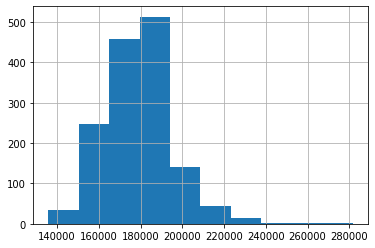

In [44]:
sub.SalePrice.hist()

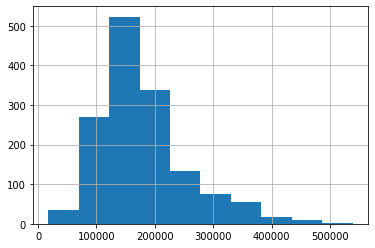

In [45]:
sub['SalePrice'] = test_pred
sub.SalePrice.hist()

In [46]:
sub.to_csv("init_sub.csv", index=False)

# Submit prediction to Kaggle site

Indicate below the performance obtained

# Export

In [47]:
ml = {'pipeline':end2end_grid_search.best_estimator_,
      'numeric_columns': num_cols,
      'categorical_columns': cat_cols,}

In [48]:
with open("ml_pipeline.pkl", 'wb') as file:
    pickle.dump(ml, file)

In [50]:
!pip freeze > requirements.txt

# Gradio App

## Basic Interface App

In [49]:
from IPython.utils.py3compat import encode
import gradio as gr
import numpy as np
import pandas as pd
import pickle


def load_saved_objets(filepath="ml_pipeline.pkl"):
    "Function to load saved objects"

    with open(filepath, "rb") as file:
        loaded_object = pickle.load(file)

    return loaded_object


###### SETUP

loaded_object = load_saved_objets()
pipeline_of_my_app = loaded_object["pipeline"]
num_cols = loaded_object['numeric_columns']
cat_cols = loaded_object['categorical_columns']


def predict(
    BsmtFullBath,
    FullBath,
    YearRemodAdd,
    MoSold,
    MasVnrArea,
    BsmtHalfBath,
    LotArea,
    KitchenAbvGr,
    _2ndFlrSF,
    _1stFlrSF,
    BedroomAbvGr,
    GarageCars,
    WoodDeckSF,
    OverallCond,
    LowQualFinSF,
    OverallQual,
    TotalBsmtSF,
    LotFrontage,
    ScreenPorch,
    TotRmsAbvGrd,
    GarageYrBlt,
    Fireplaces,
    BsmtFinSF2,
    GrLivArea,
    PoolArea,
    BsmtFinSF1,
    EnclosedPorch,
    HalfBath,
    MiscVal,
    GarageArea,
    YearBuilt,
    MSSubClass,
    OpenPorchSF,
    YrSold,
    _3SsnPorch,
    BsmtUnfSF,
    SaleType,
    BsmtCond,
    LotConfig,
    LotShape,
    RoofStyle,
    PavedDrive,
    Functional,
    RoofMatl,
    Electrical,
    Condition1,
    LandSlope,
    BsmtQual,
    BsmtFinType1,
    Foundation,
    Heating,
    GarageQual,
    CentralAir,
    Utilities,
    GarageFinish,
    KitchenQual,
    GarageCond,
    ExterQual,
    Neighborhood,
    Condition2,
    HouseStyle,
    BsmtFinType2,
    Exterior1st,
    Exterior2nd,
    FireplaceQu,
    GarageType,
    LandContour,
    Street,
    SaleCondition,
    HeatingQC,
    MasVnrType,
    BldgType,
    BsmtExposure,
    MSZoning,
    ExterCond,
):
    """main function to collect the inputs process them and outpu the predicition"""

    df = pd.DataFrame(
        [
            [
                BsmtFullBath,
                FullBath,
                YearRemodAdd,
                MoSold,
                MasVnrArea,
                BsmtHalfBath,
                LotArea,
                KitchenAbvGr,
                _2ndFlrSF,
                _1stFlrSF,
                BedroomAbvGr,
                GarageCars,
                WoodDeckSF,
                OverallCond,
                LowQualFinSF,
                OverallQual,
                TotalBsmtSF,
                LotFrontage,
                ScreenPorch,
                TotRmsAbvGrd,
                GarageYrBlt,
                Fireplaces,
                BsmtFinSF2,
                GrLivArea,
                PoolArea,
                BsmtFinSF1,
                EnclosedPorch,
                HalfBath,
                MiscVal,
                GarageArea,
                YearBuilt,
                MSSubClass,
                OpenPorchSF,
                YrSold,
                _3SsnPorch,
                BsmtUnfSF,
                SaleType,
                BsmtCond,
                LotConfig,
                LotShape,
                RoofStyle,
                PavedDrive,
                Functional,
                RoofMatl,
                Electrical,
                Condition1,
                LandSlope,
                BsmtQual,
                BsmtFinType1,
                Foundation,
                Heating,
                GarageQual,
                CentralAir,
                Utilities,
                GarageFinish,
                KitchenQual,
                GarageCond,
                ExterQual,
                Neighborhood,
                Condition2,
                HouseStyle,
                BsmtFinType2,
                Exterior1st,
                Exterior2nd,
                FireplaceQu,
                GarageType,
                LandContour,
                Street,
                SaleCondition,
                HeatingQC,
                MasVnrType,
                BldgType,
                BsmtExposure,
                MSZoning,
                ExterCond,
            ]
        ],
        columns=num_cols + cat_cols,
    ).replace("", np.nan)

    df[cat_cols] = df[cat_cols].astype("object")  # solution of the bug
    print("df ")
    print(df.shape)
    # print(df.head())
    print(df.to_dict())

    model_output = pipeline_of_my_app.predict(df)

    print(type(model_output))
    print(model_output.shape)
    print(model_output)

    return model_output


demo = gr.Interface(
    fn=predict,
    inputs=["number" for i in (num_cols)]
    + [
        gr.inputs.Dropdown(
            choices=choices.tolist(),
            type="value",
            label=lab,
            default=choices.tolist()[0],
        )
        for (lab, choices) in zip(cat_cols, encoder_categories)
    ],
    outputs=["number"],
)


demo.launch(
    share=True,
    # debug=True,
)


/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:216: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://3cab9591588647ef.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


## Personalized App

In [61]:
from IPython.utils.py3compat import encode
import gradio as gr
import numpy as np
import pandas as pd
import pickle


def load_saved_objets(filepath="ml_pipeline.pkl"):
    "Function to load saved objects"

    with open(filepath, "rb") as file:
        loaded_object = pickle.load(file)

    return loaded_object


###### SETUP

loaded_object = load_saved_objets()
pipeline_of_my_app = loaded_object["pipeline"]
num_cols = loaded_object['numeric_columns']
cat_cols = loaded_object['categorical_columns']


def predict(
    BsmtFullBath,
    FullBath,
    YearRemodAdd,
    MoSold,
    MasVnrArea,
    BsmtHalfBath,
    LotArea,
    KitchenAbvGr,
    _2ndFlrSF,
    _1stFlrSF,
    BedroomAbvGr,
    GarageCars,
    WoodDeckSF,
    OverallCond,
    LowQualFinSF,
    OverallQual,
    TotalBsmtSF,
    LotFrontage,
    ScreenPorch,
    TotRmsAbvGrd,
    GarageYrBlt,
    Fireplaces,
    BsmtFinSF2,
    GrLivArea,
    PoolArea,
    BsmtFinSF1,
    EnclosedPorch,
    HalfBath,
    MiscVal,
    GarageArea,
    YearBuilt,
    MSSubClass,
    OpenPorchSF,
    YrSold,
    _3SsnPorch,
    BsmtUnfSF,
    SaleType,
    BsmtCond,
    LotConfig,
    LotShape,
    RoofStyle,
    PavedDrive,
    Functional,
    RoofMatl,
    Electrical,
    Condition1,
    LandSlope,
    BsmtQual,
    BsmtFinType1,
    Foundation,
    Heating,
    GarageQual,
    CentralAir,
    Utilities,
    GarageFinish,
    KitchenQual,
    GarageCond,
    ExterQual,
    Neighborhood,
    Condition2,
    HouseStyle,
    BsmtFinType2,
    Exterior1st,
    Exterior2nd,
    FireplaceQu,
    GarageType,
    LandContour,
    Street,
    SaleCondition,
    HeatingQC,
    MasVnrType,
    BldgType,
    BsmtExposure,
    MSZoning,
    ExterCond,
):
    """main function to collect the inputs process them and outpu the predicition"""

    df = pd.DataFrame(
        [
            [
                BsmtFullBath,
                FullBath,
                YearRemodAdd,
                MoSold,
                MasVnrArea,
                BsmtHalfBath,
                LotArea,
                KitchenAbvGr,
                _2ndFlrSF,
                _1stFlrSF,
                BedroomAbvGr,
                GarageCars,
                WoodDeckSF,
                OverallCond,
                LowQualFinSF,
                OverallQual,
                TotalBsmtSF,
                LotFrontage,
                ScreenPorch,
                TotRmsAbvGrd,
                GarageYrBlt,
                Fireplaces,
                BsmtFinSF2,
                GrLivArea,
                PoolArea,
                BsmtFinSF1,
                EnclosedPorch,
                HalfBath,
                MiscVal,
                GarageArea,
                YearBuilt,
                MSSubClass,
                OpenPorchSF,
                YrSold,
                _3SsnPorch,
                BsmtUnfSF,
                SaleType,
                BsmtCond,
                LotConfig,
                LotShape,
                RoofStyle,
                PavedDrive,
                Functional,
                RoofMatl,
                Electrical,
                Condition1,
                LandSlope,
                BsmtQual,
                BsmtFinType1,
                Foundation,
                Heating,
                GarageQual,
                CentralAir,
                Utilities,
                GarageFinish,
                KitchenQual,
                GarageCond,
                ExterQual,
                Neighborhood,
                Condition2,
                HouseStyle,
                BsmtFinType2,
                Exterior1st,
                Exterior2nd,
                FireplaceQu,
                GarageType,
                LandContour,
                Street,
                SaleCondition,
                HeatingQC,
                MasVnrType,
                BldgType,
                BsmtExposure,
                MSZoning,
                ExterCond,
            ]
        ],
        columns=num_cols + cat_cols,
    ).replace("", np.nan)

    df[cat_cols] = df[cat_cols].astype("object")  # solution of the bug
    print("df ")
    print(df.shape)
    # print(df.head())
    print(df.to_dict())

    model_output = pipeline_of_my_app.predict(df)

    print(type(model_output))
    print(model_output.shape)
    print(model_output)

    return model_output


inputs = []

with gr.Blocks() as demo:
    gr.Markdown(
        """# House Price Predicting App
        This app estimate the cost of house based on the descriptive information.
    """)
    with gr.Row(): #main frame 
        
        with gr.Column(): #col 1 : for num features

            gr.Markdown("""## Numeric variables
            Please fill the numeric details for prediction""")

            for i in num_cols:
                inputs.append(gr.Number(label=f"Input {i} "))
        
        with gr.Column(): #col 2 : for cat features

            gr.Markdown("""## Categorical variables
            Please fill the categorical details for prediction""")

            for (lab, choices) in zip(cat_cols, encoder_categories):
                inputs.append(gr.inputs.Dropdown(
                choices=choices.tolist(),
                type="value",
                label=f"Select {lab}",
                default=choices.tolist()[0],))
            
    with gr.Row():
        make_prediction = gr.Button("Predict")
    
    with gr.Row():
        output_prediction = gr.Number(label="Predicted Price")
    make_prediction.click(predict, inputs, output_prediction)


demo.launch(
    share=True,
    # debug=True
)

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:216: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://1a13a3fa594ad5fb.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
